# Client Retention and Gender Analysis

This notebook analyzes the `clients_months.csv` dataset to understand client retention, gender distribution, and gym attendance frequency.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

In [2]:
# Load the processed dataset containing client routine information per month
df = pd.read_csv('../data/04-processed/gym_routines_by_month.csv')

# Ensure the 'date' column is recognized as datetime objects for time-series analysis
df['date'] = pd.to_datetime(df['date'], format='%m/%Y')

df.head()

,client_id,date,gender,day
0,0,2023-01-01,M,1
1,0,2022-08-01,M,1
2,0,2022-09-01,M,1
3,0,2022-11-01,M,1
4,1,2024-01-01,M,3


In [3]:
# Filter out the initial data point (July 2022) which only contains two routines,
# making it an outlier for statistical comparisons.
print(f"Rows before filter: {df.shape[0]}")
df = df[df['date'] != '2022-07']
print(f"Rows after filter: {df.shape[0]}")

Rows before filter: 3127
Rows after filter: 3125


In [4]:
# Calculate the average monthly attendance frequency (days per month) for each individual client
# and attach it as a new feature to the dataframe.
df['average_of_days_per_routine'] = df.groupby('client_id')['day'].transform('mean')
df.sample(5)

,client_id,date,gender,day,average_of_days_per_routine
596,49,2023-09-01,F,1,1.000000
2252,242,2024-01-01,F,1,1.000000
1467,129,2023-04-01,F,1,1.150000
1846,173,2024-03-01,F,1,2.153846
1692,152,2025-03-01,F,1,1.000000


In [5]:
df['last_month'] = df.groupby('client_id')['date'].transform('max')
df['routines_count'] = df.groupby('client_id')['date'].transform('count')

## Gender Analysis

Let's look at the distribution of clients by gender.

C:\Users\alejo\AppData\Local\Temp\ipykernel_10384\1944413089.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gender', order=['F', 'M'], palette={'F': 'salmon', 'M': 'skyblue'})


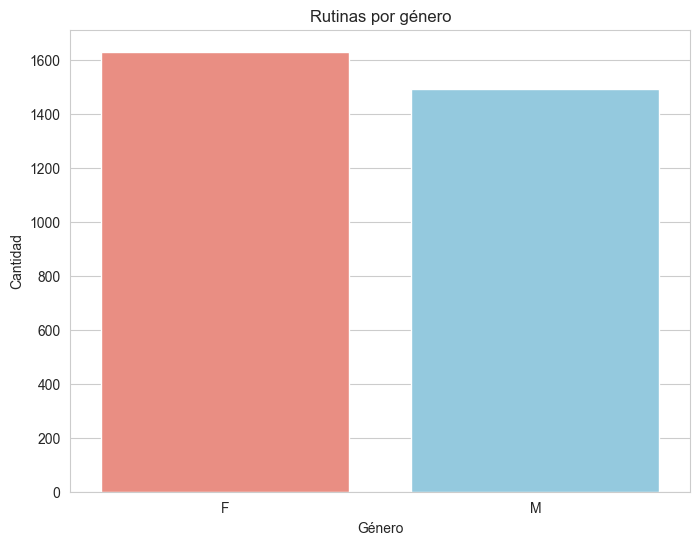

In [6]:
# Visualize the volume of routine records distributed by gender
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='gender', order=['F', 'M'], palette={'F': 'salmon', 'M': 'skyblue'})
plt.title('Rutinas por género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()

Unique clients by gender:
gender
F    332
M    273
Name: count, dtype: int64


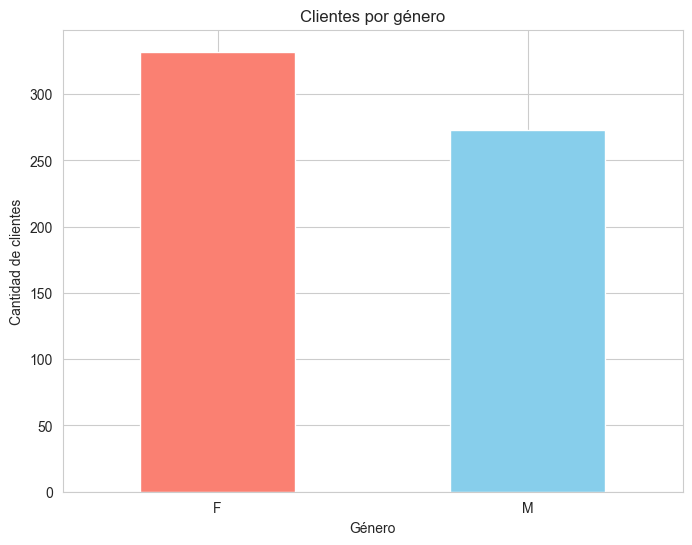

In [7]:
# Calculate and visualize the number of unique clients for each gender,
# preventing bias from clients who log more frequent routines.
unique_clients_gender = df.drop_duplicates(subset=['client_id'])['gender'].value_counts()
print("Unique clients by gender:")
print(unique_clients_gender)

plt.figure(figsize=(8, 6))
unique_clients_gender.plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Clientes por género')
plt.xlabel('Género')
plt.ylabel('Cantidad de clientes')
plt.xticks(rotation=0)
plt.show()

In [8]:
# Calculate the percentage of routines performed by male clients
df[df["gender"] == "M"].shape[0] / df.shape[0]

0.47808

## Retention Analysis (Cohort Analysis)

We will perform a cohort analysis to track client retention over time. 
A cohort is defined as a group of users who started their activity in the same month.

In [9]:
# Logistic function to calculate and structure the retention rate for cohort analysis
def get_retention(df):
    # 1. Define the cohort month for each client as their first ever appearance in the dataset
    df['cohort_month'] = df.groupby('client_id')['date'].transform('min')

    # Helper function to extract month/year as integers for offset calculation
    def get_date_int(df, column):
        year = df[column].dt.year
        month = df[column].dt.month
        return year, month

    activity_year, activity_month = get_date_int(df, 'date')
    cohort_year, cohort_month = get_date_int(df, 'cohort_month')

    # 2. Calculate the 'cohort_index', which is the relative month count since the start
    years_diff = activity_year - cohort_year
    months_diff = activity_month - cohort_month
    df['cohort_index'] = years_diff * 12 + months_diff + 1

    # 3. Aggregate unique client counts by cohort start month and relative activity month
    grouping = df.groupby(['cohort_month', 'cohort_index'])
    cohort_data = grouping['client_id'].apply(pd.Series.nunique).reset_index()

    # 4. Transform the long-format data into a pivot table (matrix form)
    cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='client_id')

    # 5. Normalize the counts by the total size of each cohort
    cohort_sizes = cohort_counts.iloc[:,0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)

    # Clean index formatting for the plot
    retention.index = retention.index.strftime('%Y-%m')
    retention.fillna(0, inplace=True)
    return retention

# Execute computation and display preview
retention = get_retention(df)
retention.head()

cohort_index,1,2,3,4,5,6,7,8,9,10,...,32,33,34,35,36,37,38,39,40,41
cohort_month,,,,,,,,,,,,,,,,,,,,,
2022-08,1.0,0.405405,0.729730,0.513514,0.297297,0.324324,0.243243,0.378378,0.405405,0.486486,...,0.108108,0.162162,0.108108,0.054054,0.054054,0.162162,0.135135,0.108108,0.108108,0.054054
2022-09,1.0,0.714286,0.428571,0.142857,0.500000,0.142857,0.214286,0.142857,0.142857,0.071429,...,0.000000,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.000000,0.071429,0.000000
2022-10,1.0,0.533333,0.466667,0.333333,0.266667,0.200000,0.266667,0.466667,0.400000,0.466667,...,0.133333,0.133333,0.200000,0.200000,0.266667,0.000000,0.200000,0.133333,0.000000,0.000000
2022-11,1.0,0.461538,0.384615,0.307692,0.076923,0.153846,0.153846,0.153846,0.153846,0.230769,...,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000
2022-12,1.0,0.333333,0.333333,0.333333,0.000000,0.333333,0.222222,0.222222,0.222222,0.222222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


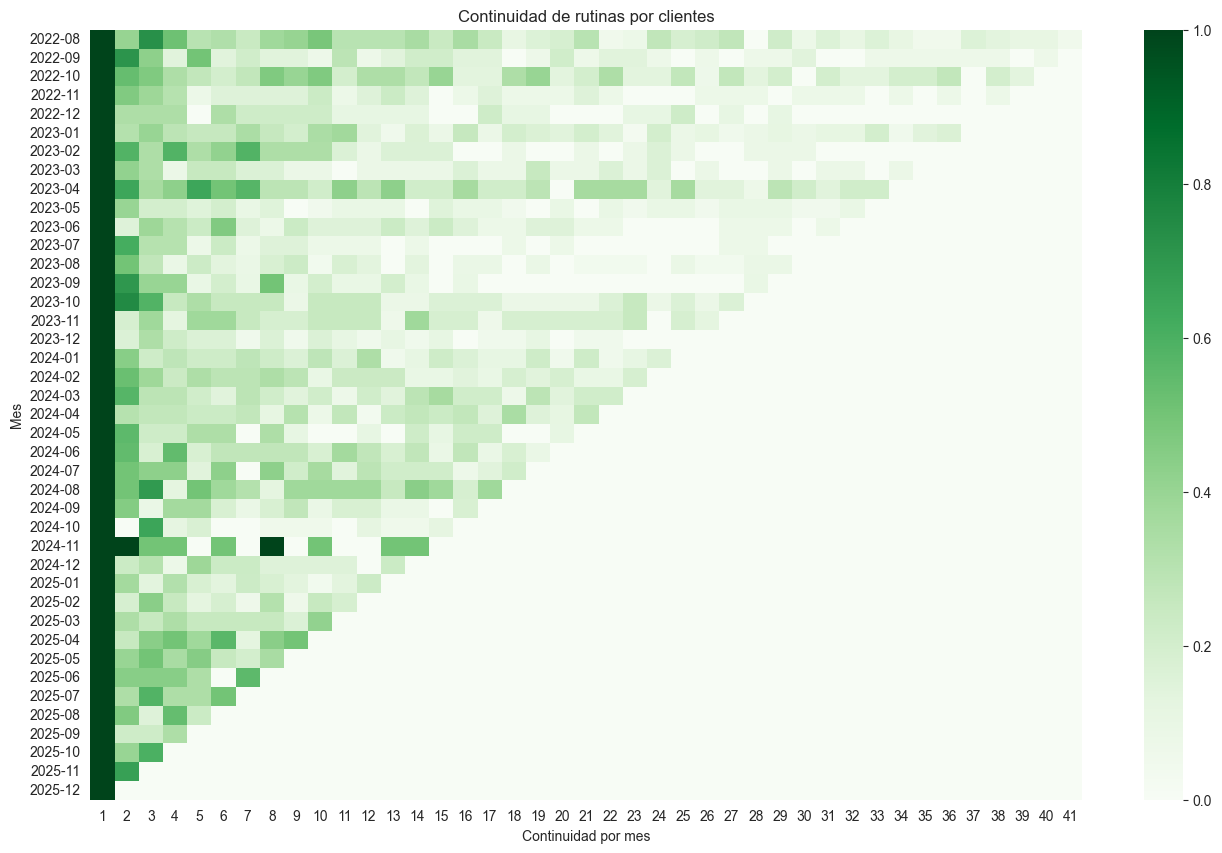

In [10]:
def plot_retention(retention):
    plt.figure(figsize=(16, 10))
    sns.heatmap(retention, fmt='.0%', cmap='Greens')
    plt.title('Continuidad de rutinas por clientes')
    plt.ylabel('Mes')
    plt.xlabel('Continuidad por mes')
    plt.show()

plot_retention(retention)

In [11]:
def get_avg_lifetime(df):
    user_lifetimes = df.groupby('client_id')['cohort_index'].nunique()
    avg_lifetime = user_lifetimes.mean()
    return avg_lifetime

print(f'Promedio de cantidad de rutinas para clientes: {get_avg_lifetime(df)}')
print(f'Promedio de cantidad de rutinas para clientes con rutinas de 4 o más días: {get_avg_lifetime(df[df["average_of_days_per_routine"] >= 4])}')
print(f'Promedio de cantidad de rutinas para clientes con rutinas de 3 o más días: {get_avg_lifetime(df[df["average_of_days_per_routine"] >= 3])}')
print(f'Promedio de cantidad de rutinas para clientes con rutinas entre 2 y 3 días: {get_avg_lifetime(df[(df["average_of_days_per_routine"] >= 2) & (df["average_of_days_per_routine"] <= 3)])}')
print(f'Promedio de cantidad de rutinas para clientes con rutinas entre 1.5 y 2 días: {get_avg_lifetime(df[(df["average_of_days_per_routine"] >= 1.5) & (df["average_of_days_per_routine"] <= 2)])}')
print(f'Promedio de cantidad de rutinas para clientes con rutinas de menos de 1.5 días: {get_avg_lifetime(df[df["average_of_days_per_routine"] < 1.5])}')

Promedio de cantidad de rutinas para clientes: 5.1652892561983474
Promedio de cantidad de rutinas para clientes con rutinas de 4 o más días: 2.8947368421052633
Promedio de cantidad de rutinas para clientes con rutinas de 3 o más días: 5.4941176470588236
Promedio de cantidad de rutinas para clientes con rutinas entre 2 y 3 días: 6.306569343065694
Promedio de cantidad de rutinas para clientes con rutinas entre 1.5 y 2 días: 4.918918918918919
Promedio de cantidad de rutinas para clientes con rutinas de menos de 1.5 días: 4.334158415841584


In [12]:
# Generate descriptive statistics for the 'persistence' of each client across months
df.groupby('client_id')['cohort_index'].describe()

,count,mean,std,min,25%,50%,75%,max
client_id,,,,,,,,
0,4.0,3.250000,2.217356,1.0,1.75,3.0,4.50,6.0
1,28.0,19.107143,11.637549,1.0,9.75,18.5,29.50,38.0
2,6.0,5.833333,3.188521,1.0,4.25,6.0,7.75,10.0
3,32.0,18.906250,11.202993,1.0,9.75,18.5,28.25,38.0
4,19.0,17.210526,12.664820,1.0,6.50,14.0,30.50,37.0
...,...,...,...,...,...,...,...,...
604,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
605,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
606,3.0,4.333333,3.055050,1.0,3.00,5.0,6.00,7.0


## Days per Routine Analysis

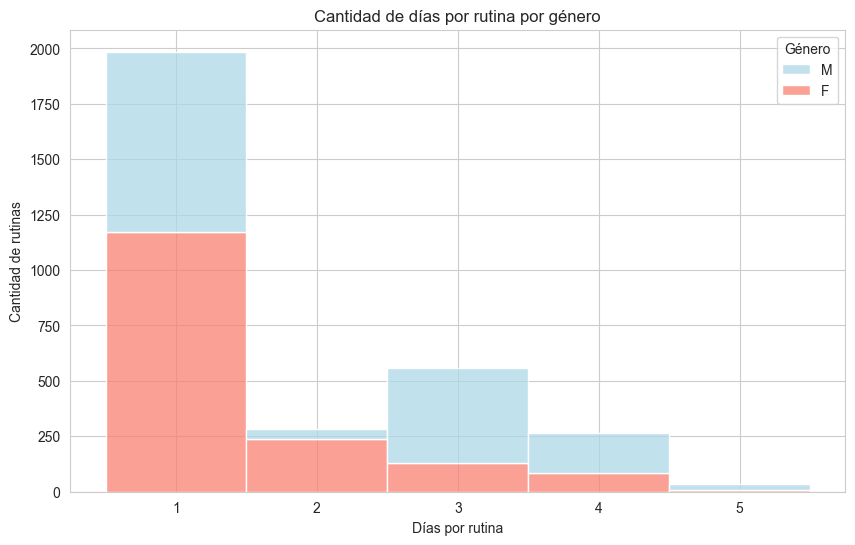

In [13]:
# Multi-layered histogram showing the distribution of attendance days per routine, split by gender
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='day', hue='gender', discrete=True, multiple='stack', palette={'F': 'salmon', 'M': 'lightblue'})
ax.get_legend().set_title('Género')
plt.title('Cantidad de días por rutina por género')
plt.xlabel('Días por rutina')
plt.ylabel('Cantidad de rutinas')
plt.xticks(range(1, 6))
plt.show()

## Count by Date

Here we visualize the number of active client records per month.

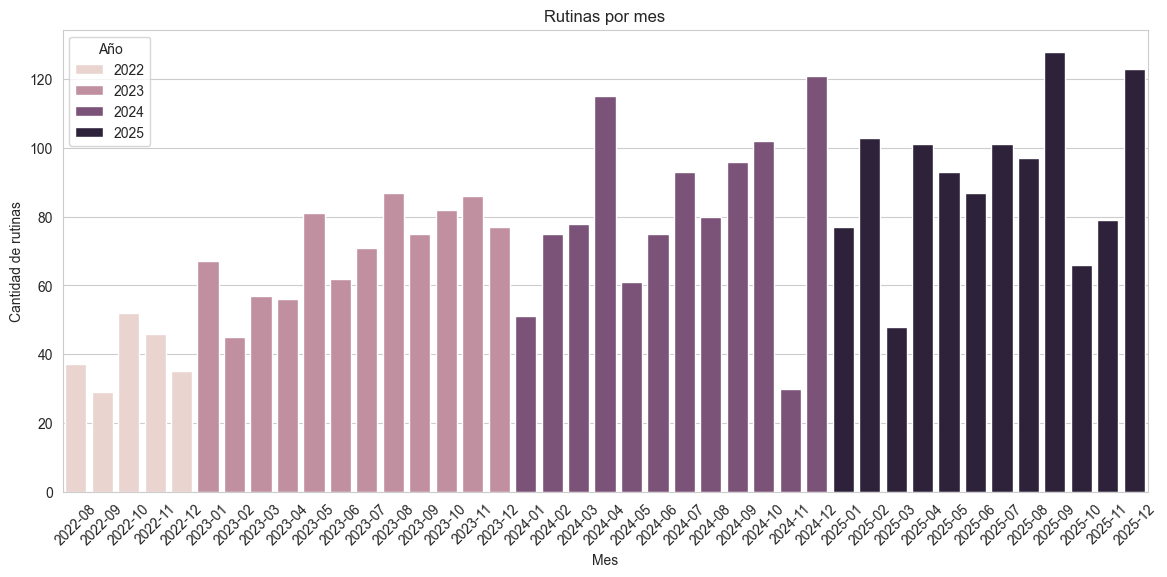

In [14]:
# Visualize the chronological distribution of routines recorded in the system per month
plt.figure(figsize=(14, 6))
df['date_str'] = df['date'].dt.strftime('%Y-%m')
df['year'] = df['date'].dt.year
sns.countplot(data=df.sort_values('date'), x='date_str', hue='year', dodge=False)
plt.title('Rutinas por mes')
plt.legend(title='Año')
plt.xlabel('Mes')
plt.ylabel('Cantidad de rutinas')
plt.xticks(rotation=45)
plt.show()

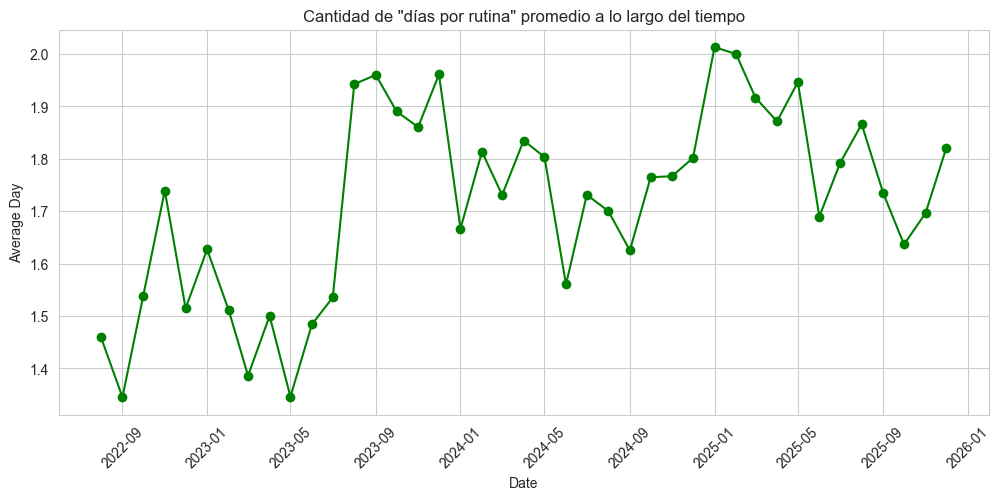

In [15]:
# Visualize the chronological distribution of the mean of days per routine
plt.figure(figsize=(12, 5))
avg_day_per_month = df.groupby('date')['day'].mean()
plt.plot(avg_day_per_month.index, avg_day_per_month.values, marker='o', color='green')
plt.title('Cantidad de "días por rutina" promedio a lo largo del tiempo')
plt.xlabel('Date')
plt.ylabel('Average Day')
plt.xticks(rotation=45)
plt.grid(True)

# Count of clients per year

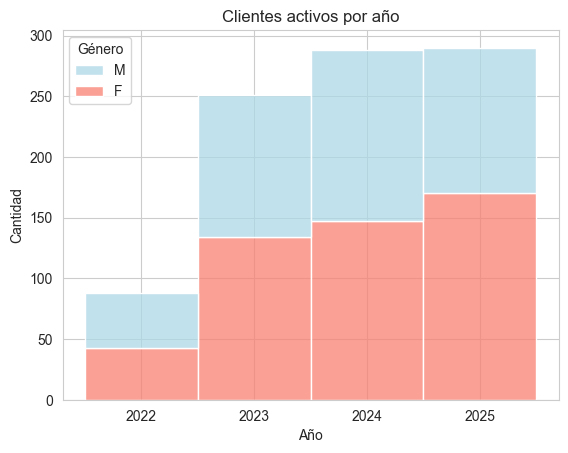

In [16]:
# Visualize the count of active clients per year
clients_by_year = df.drop_duplicates(subset=['year', 'client_id'])
ax = sns.histplot(data=clients_by_year, x='year', discrete=True, hue="gender", palette={'F': 'salmon', 'M': 'lightblue'}, multiple="stack")
ax.get_legend().set_title('Género')
plt.title('Clientes activos por año')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.xticks(sorted(clients_by_year['year'].unique()))
plt.show()

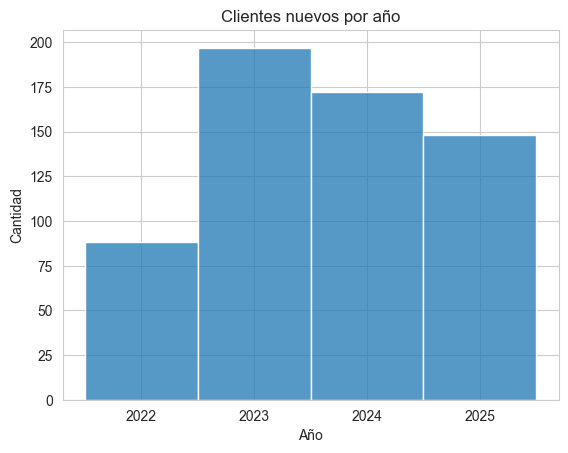

In [17]:
# Visualize the count of new clients per year
sns.histplot(pd.to_datetime(df.groupby(["client_id","gender"])['cohort_month'].describe()["min"]).dt.year, discrete=True)
plt.title('Clientes nuevos por año')
plt.xlabel('Año')
plt.xticks(sorted(clients_by_year['year'].unique()))
plt.ylabel('Cantidad')
plt.show()

# Routines per client

In [18]:
routines_per_client = df.groupby(["client_id"])["date"].count().reset_index(name="count")

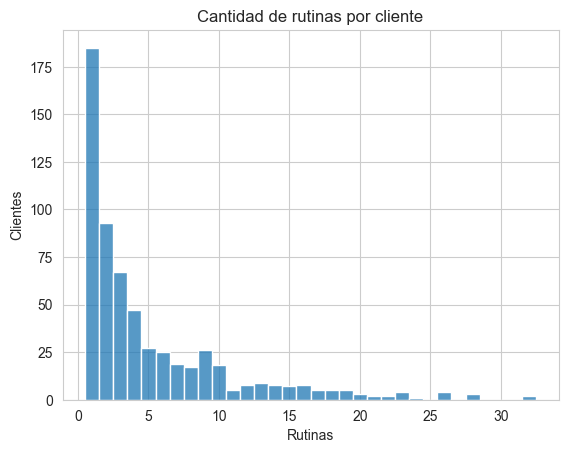

In [19]:
# Visualize the number of routines per client
sns.histplot(data=routines_per_client, x="count", discrete=True, multiple="stack")
plt.title("Cantidad de rutinas por cliente")
plt.xlabel("Rutinas")
plt.ylabel("Clientes")
plt.show()

# Exporting new csv with features by client

In [26]:
client_features = df.drop_duplicates("client_id").drop(columns=["date","day","cohort_index","date_str","year"])
client_features.head(5)

,client_id,gender,average_of_days_per_routine,last_month,routines_count,cohort_month
0,0,M,1.000000,2023-01-01,4,2022-08-01
4,1,M,2.357143,2025-09-01,28,2022-08-01
32,2,M,3.500000,2023-05-01,6,2022-08-01
38,3,F,2.625000,2025-11-01,32,2022-10-01
70,4,M,1.736842,2025-08-01,19,2022-08-01


In [27]:
# Taking useful columns
features = client_features[['average_of_days_per_routine', 'routines_count']].copy()
    
# Encode gender
features['gender_encoded'] = client_features['gender'].map({'M': 0, 'F': 1})
features['gender_encoded'] = features['gender_encoded'].fillna(-1)

# Months diff: get the difference between the first and last month.
client_features['last_month'] = pd.to_datetime(client_features['last_month'])
client_features['cohort_month'] = pd.to_datetime(client_features['cohort_month'])
features['months_diff'] = (client_features['last_month'].dt.year - client_features['cohort_month'].dt.year) * 12 + (client_features['last_month'].dt.month - client_features['cohort_month'].dt.month)

In [28]:
features

,average_of_days_per_routine,routines_count,gender_encoded,months_diff
0,1.000000,4,0,5
4,2.357143,28,0,37
32,3.500000,6,0,9
38,2.625000,32,1,37
70,1.736842,19,0,36
...,...,...,...,...
3114,1.000000,1,1,0
3115,3.000000,1,1,0
3116,1.000000,3,1,6
3119,2.000000,7,1,7


In [30]:
features.to_csv("../data/04-processed/client_features.csv", index=False)